In [1]:
import os
import pickle
import csv
import numpy as np
import pandas as pd

from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import LinearSVR
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold

import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy.stats as stats
from statsmodels.api import OLS
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from itertools import chain

pd.set_option('display.float_format', '{:.4f}'.format)
np.set_printoptions(precision=4)

In [2]:
dir = os.getcwd()
data_dir = dir+"/data/"

# Load test results
data = []
data_file = data_dir+"tap_consistency.csv"
with open(data_file) as results:
    reader = csv.reader(results)
    for row in reader:
        data.append(row)
    results.close()

data = np.asarray(data, dtype=float)
print(data.shape)

(43, 96)


In [3]:
## Define some things
n_subjects = len(data)
test_length = 32
n_tests = 3

# Each test has n subjects each doing 32 taps
# 0 = low midi=[0,42]
# 1 = hi  midi=(42,84]
# 2 = mid midi=(84,127]
tap_by_test = np.array([[[0.0 for x in range(test_length)] for y in range(n_subjects)] for z in range(n_tests)], dtype=float)

# Each subject has 3 tests of 32 taps
tap_by_subject = np.array([[[0.0 for x in range(test_length)] for y in range(n_tests)] for z in range(n_subjects)], dtype=float)

# Fill the arrays
for subj in range(n_subjects):
    line = data[subj] # 96 long (32 x 3)
    for test in range(n_tests): # 3
        tap_by_test[test][subj] = line[test*32:(test+1)*32]
        tap_by_subject[subj][test]= line[test*32:(test+1)*32]

In [57]:
## Plotstyles for Consistency ##
## Labels and Titles ##
title_style={ 
    'fontsize':14,
    'fontfamily':'serif',
    'fontweight':'book'
}
label_style={
    'fontsize':12,
    'fontfamily':'sans-serif',
    'fontweight':'book'
}
## Scatters -----------
scatter_style={
    'color':'dimgrey',
    'marker':'.',
    'linewidth':0.5,
    'alpha':0.6
}
tap_scatter_style={
    'marker':'x',
    'linestyle':'--',
    'linewidth':1,
    'alpha':0.8
}
## Lines -----------
dashed_line_style={
    'color':'dimgrey',
    'linestyle':'--',
    'alpha':0.8,
    'linewidth':0.8
}
solid_line_style={
    'color':'dimgrey',
    'linestyle':'-',
    'alpha':0.9,
    'linewidth':0.8
}

colors_light=['lightgreen','lightblue','mediumpurple']
colors_dark=['forestgreen', 'royalblue','indigo']

## Boxplots -----------
box_style={
    "patch_artist":True,
    "showfliers":True,
    "widths":0.33,
    "medianprops":{"color":'black'}
}
boxf_style={
    "marker":'x', 
    "markersize":'5',
    "alpha":0.6
}
boxb_style={
    "alpha":0.8,
    "facecolor":'lightgrey',
    "linewidth":0.8

}

box_style2={
    "widths":0.5,
    "patch_artist":True,
    "medianprops":{"color":'black'},
    "showfliers":False
}

mpl.rcParams['hatch.linewidth'] = 2
mpl.rcParams['hatch.color'] = 'black'


In [38]:
label_size=14
font_size=16

/var/folders/_m/vj49vq3972b166bph370j1kw0000gn/T/ipykernel_1225/1296002567.py:37: UserWarning: Legend does not support handles for list instances.
A proxy artist may be used instead.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#controlling-the-legend-entries
  plt.legend(handles=[bp_low["boxes"][0], bp_mid["boxes"][0], bp_high["boxes"][0], linelow,linemid, linehigh, lm_boundary, mh_boundary], fontsize="x-large", \


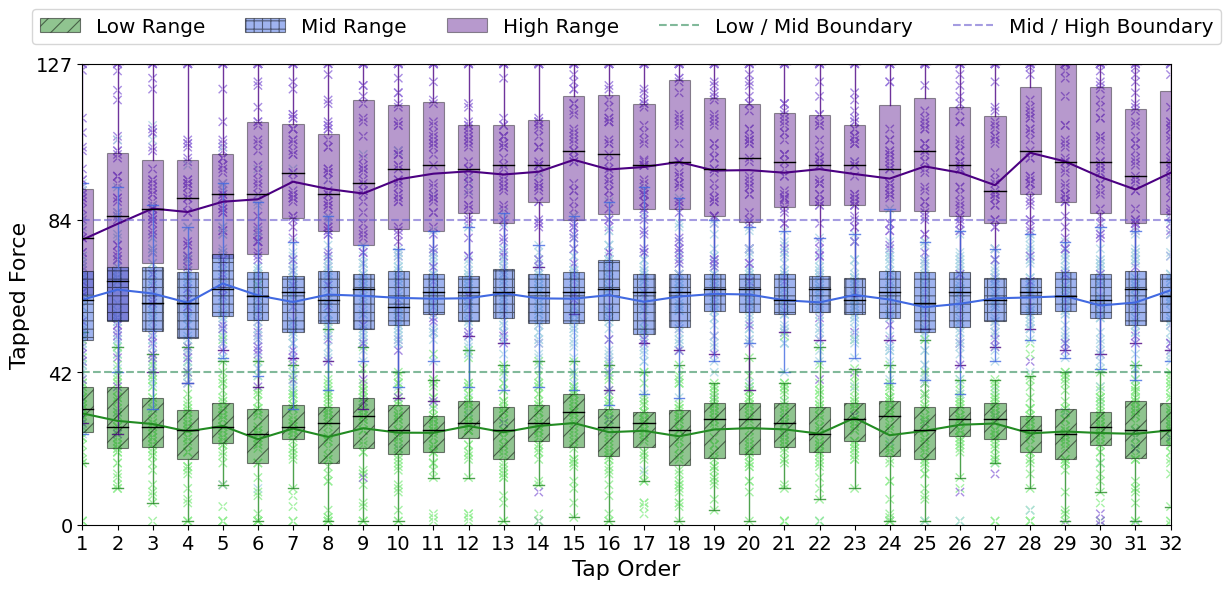

In [39]:
## Graph over Time
fig = plt.figure(figsize=(13,6))
ax = fig.add_subplot()

index = np.arange(test_length)+1

low = tap_by_test[0]
mid = tap_by_test[2]
high= tap_by_test[1]

for i in range(n_subjects):
    ax.scatter(index, low[i,:], color=colors_light[0], **tap_scatter_style)
    ax.scatter(index, mid[i,:], color=colors_light[1], **tap_scatter_style)
    ax.scatter(index, high[i,:], color=colors_light[2], **tap_scatter_style)

bp_low = ax.boxplot(low, boxprops={**boxb_style,'facecolor':colors_dark[0], "alpha":0.5, "hatch":"//"}, \
                    whiskerprops={"color":colors_dark[0], "alpha":0.8}, capprops={"color":colors_dark[0], "alpha":0.8}, **box_style2)
bp_high = ax.boxplot(high, boxprops={**boxb_style,'facecolor':colors_dark[2], "alpha":0.4}, \
                    whiskerprops={"color":colors_dark[2], "alpha":0.8}, capprops={"color":colors_dark[2], "alpha":0.8},**box_style2)
bp_mid = ax.boxplot(mid, boxprops={**boxb_style,'facecolor':colors_dark[1], "alpha":0.5, "hatch":"++"}, \
                    whiskerprops={"color":colors_dark[1], "alpha":0.8}, capprops={"color":colors_dark[1], "alpha":0.8},**box_style2)

linelow = ax.plot(index, np.mean(low, axis=0), color=colors_dark[0], label="Mean Tap Low")
linemid = ax.plot(index, np.mean(mid, axis=0), color=colors_dark[1], label="Mean Tap Mid")
linehigh = ax.plot(index, np.mean(high, axis=0), color=colors_dark[2], label="Mean Tap High")


lm_boundary = ax.axhline(y=42,color='seagreen', alpha=0.6, linestyle='--', label='Low / Mid Boundary')
mh_boundary = ax.axhline(y=84,color='slateblue', alpha=0.6, linestyle='--', label='Mid / High Boundary')

ax.set(ylim=[0,127], yticks=[0,42,84,127], xlim=[1,32],xticks=index)
font_size=16
ax.tick_params(labelsize=14)
#ax.set_title(f"Progressive Tapping Consistency over all Subjects", fontsize=14, fontfamily='serif',fontweight='book')
ax.set_xlabel("Tap Order", fontsize=font_size, fontfamily='sans-serif')
ax.set_ylabel("Tapped Force", fontsize=font_size, fontfamily='sans-serif')
plt.legend(handles=[bp_low["boxes"][0], bp_mid["boxes"][0], bp_high["boxes"][0], linelow,linemid, linehigh, lm_boundary, mh_boundary], fontsize="x-large", \
           labels=["Low Range","Mid Range","High Range","Mean Tap Low", "Mean Tap Mid", "Mean Tap High",'Low / Mid Boundary','Mid / High Boundary'],ncols=5,loc='upper center', bbox_to_anchor=(0.5, 1.14))
fig.tight_layout()
plt.show()


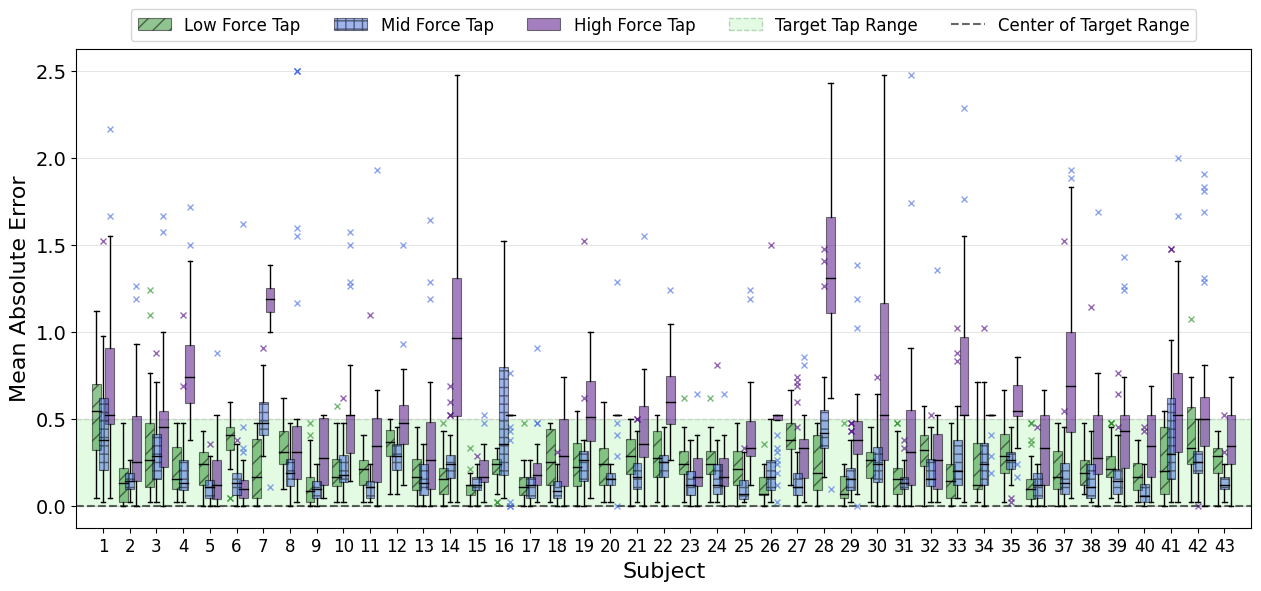

In [59]:
## Graph by Subject ##

fig = plt.figure(figsize=(13,6))
ax = fig.add_subplot()
subjidx = np.arange(n_subjects)+1
ax.grid(color='lightgray', linestyle='-', linewidth=0.6, alpha=0.7, axis='y')

# shift for 3x boxplot
pos_low = subjidx - 0.25
pos_high = subjidx + 0.25

# target rectangle
line = ax.axhline(y=0,color='black', alpha=0.6, linestyle='--', label='Middle of Target Range')
p1 = (n_subjects+1, 0.5) #0.5 as it is 50% of target range, and we are using absolute value. 
p2 = (0.0,0.0)
rect = mpl.patches.Rectangle((p2[0], p1[1]), p1[0] - p2[0], p2[1] - p1[1], linewidth=1, edgecolor='darkgreen', facecolor='lightgreen', alpha=0.25, linestyle='--', label='Target Range (+/-)')
ax.add_patch(rect)

# abs. & normalize to target range. 42 is size of target range.
_tap_by_test=tap_by_test.copy()
_tap_by_test_norm = tap_by_test.copy()
_tap_by_test_midi = tap_by_test.copy()
for i in range(n_subjects):
    _tap_by_test[0][i] = np.abs((tap_by_test[0][i]-21) / 42)
    _tap_by_test[1][i] = np.abs((tap_by_test[1][i]-105) / 42)
    _tap_by_test[2][i] = np.abs((tap_by_test[2][i]-63) / 42)

## for midi perspective
for i in range(n_subjects):
    _tap_by_test_midi[0][i] = (tap_by_test[0][i]-21)
    _tap_by_test_midi[1][i] = (tap_by_test[1][i]-105)
    _tap_by_test_midi[2][i] = (tap_by_test[2][i]-63)

## for whole range perspective
for i in range(n_subjects):
    _tap_by_test_norm[0][i] = np.abs((tap_by_test[0][i]-21) / 127)
    _tap_by_test_norm[1][i] = np.abs((tap_by_test[1][i]-105) / 127)
    _tap_by_test_norm[2][i] = np.abs((tap_by_test[2][i]-63) / 127)

    
mpl.rcParams['hatch.linewidth'] = 1
bp1_low = ax.boxplot(_tap_by_test[0].T, positions=pos_low, **box_style, boxprops={**boxb_style,"facecolor":colors_dark[0], "alpha":0.5, "hatch":"//"}, flierprops={"markeredgecolor":colors_dark[0], **boxf_style})
bp1_mid = ax.boxplot(_tap_by_test[1].T, positions=pos_high, **box_style, boxprops={**boxb_style,"facecolor":colors_dark[2], "alpha":0.5}, flierprops={"markeredgecolor":colors_dark[1], **boxf_style})
bp1_high = ax.boxplot(_tap_by_test[2].T, positions=subjidx, **box_style, boxprops={**boxb_style,"facecolor":colors_dark[1], "alpha":0.5,"hatch":"++"}, flierprops={"markeredgecolor":colors_dark[2], **boxf_style})

ax.set(xlim=[0,n_subjects+1], xticks=subjidx, xticklabels=subjidx)

#ax.set_title(f"Subject Mean Err. for Tap Consistency per Target Range", fontsize=14, fontfamily='serif',fontweight='book')
ax.set_xlabel("Subject", fontsize=font_size, fontfamily='sans-serif')
ax.set_ylabel("Mean Absolute Error", fontsize=font_size, fontfamily='sans-serif')

# Add and Remove the dummy lines to make legend work
line1, = ax.plot([1,1], color='blue')
line2, = ax.plot([1,1], color='green')
line3, = ax.plot([1,1], color='red')
line1.set_visible(False)
line2.set_visible(False)
line3.set_visible(False)
ax.tick_params(axis="y", labelsize=label_size)
ax.tick_params(axis="x", labelsize=label_size-2)

ax.legend([bp1_low["boxes"][0],  bp1_high["boxes"][0],bp1_mid["boxes"][0], rect, line], ('Low Force Tap', 'Mid Force Tap', 'High Force Tap', 'Target Tap Range', 'Center of Target Range'), fontsize="large",ncols=5,loc='upper center', bbox_to_anchor=(0.5, 1.10))
fig.tight_layout()
plt.show()


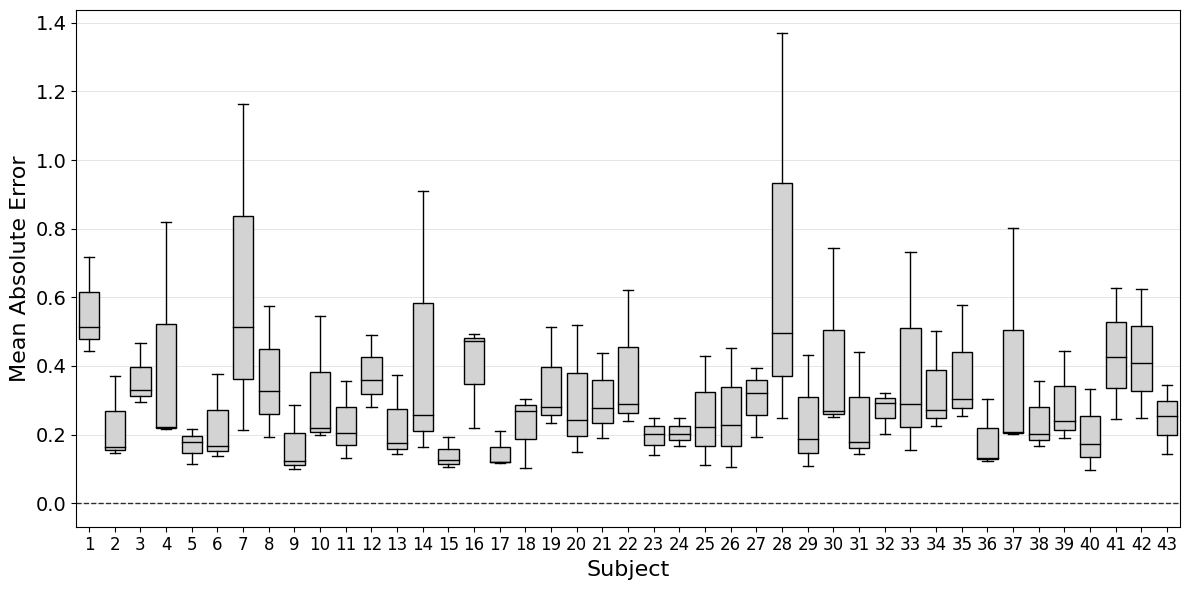

In [51]:
## Plot Error by Subject ##
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot()
ax.grid(color='lightgray', linestyle='-', linewidth=0.6, alpha=0.7, axis='y')
bp=ax.boxplot(np.mean(_tap_by_test,axis=2), patch_artist=True,widths=0.8, medianprops={"color":"black"}, boxprops={"facecolor":"lightgrey"})
ax.axhline(y=0.0,color='black', alpha=0.8, linestyle='--', linewidth=1)
ax.set_xlabel("Subject", fontsize=font_size, fontfamily='sans-serif')
ax.set_ylabel("Mean Absolute Error", fontsize=font_size, fontfamily='sans-serif')
ax.tick_params(axis="y", labelsize=label_size)
ax.tick_params(axis="x", labelsize=label_size-2)
fig.tight_layout()
plt.show()

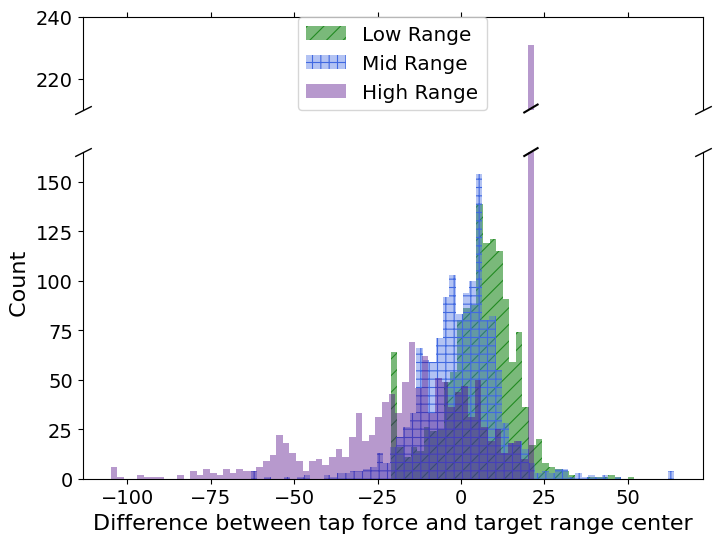

In [43]:
## Graph MIDI difference distributions ##
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6), sharex=True, gridspec_kw={'height_ratios': [1,3.5]})

test_low = _tap_by_test_midi[0].flatten()
test_high = _tap_by_test_midi[1].flatten()
test_mid = _tap_by_test_midi[2].flatten()

bin_width = 2
num_bins = int(np.ceil((np.max(test_low)-np.min(test_low)) / bin_width))
bin_edges_low = np.linspace(np.min(test_low), np.max(test_low), num_bins + 1)

num_bins = int(np.ceil((np.max(test_mid)-np.min(test_mid)) / bin_width))
bin_edges_mid = np.linspace(np.min(test_mid), np.max(test_mid), num_bins + 1)

num_bins = int(np.ceil((np.max(test_high)-np.min(test_high)) / bin_width))
bin_edges_high = np.linspace(np.min(test_high), np.max(test_high), num_bins + 1)

mpl.rcParams['hatch.color'] = colors_dark[0]
low = ax1.hist(test_low, bins=bin_edges_low, alpha=0.6, color=colors_dark[0], hatch="//", label="Low Range")
low = ax2.hist(test_low, bins=bin_edges_low, alpha=0.6, color=colors_dark[0], hatch="//", label="Low Range")
mpl.rcParams['hatch.color'] = colors_dark[1]
mid = ax1.hist(test_mid, bins=bin_edges_mid, alpha=0.4, color=colors_dark[1], hatch="++", label="Mid Range")
mid = ax2.hist(test_mid, bins=bin_edges_mid, alpha=0.4, color=colors_dark[1], hatch="++", label="Mid Range")
high = ax1.hist(test_high, bins=bin_edges_high, alpha=0.4, color=colors_dark[2], label="High Range")
high = ax2.hist(test_high, bins=bin_edges_high, alpha=0.4, color=colors_dark[2], label="High Range")

ax2.set_ylim([0,165])
ax1.set_ylim([210,240])
ax1.set_yticks([220,240])
ax1.set_yticklabels([220,240])
ax1.spines.bottom.set_visible(False)
ax2.spines.top.set_visible(False)
ax1.xaxis.tick_top()
ax1.tick_params(labeltop=False)  # don't put tick labels at the top
ax2.xaxis.tick_bottom()
d = 0.5
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
              linestyle="none", color='k', mec='k', mew=1, clip_on=False)
ax1.plot([0, 1], [0, 0], transform=ax1.transAxes, **kwargs)
ax2.plot([0, 1], [1, 1], transform=ax2.transAxes, **kwargs)
ax2.set_ylabel("         Count", fontsize=font_size, fontfamily='sans-serif')
ax2.set_xlabel("Difference between tap force and target range center", fontsize=font_size, fontfamily='sans-serif')
line_length = 4  # Length of the line
ax2.plot([19, 23], [163,167],color='black', clip_on=False)
ax2.plot([19, 23], [185,189],color='black', clip_on=False)
ax1.legend(loc="center", fontsize="x-large")
ax1.tick_params(labelsize=label_size)
ax2.tick_params(labelsize=label_size)
plt.show()

In [9]:
## Statistics for comparing 3 Tap Ranges ##
lows = _tap_by_test[0] # (43,32)
mids = _tap_by_test[2] # 
highs = _tap_by_test[1]#

anova = stats.f_oneway(np.mean(lows, axis=1), np.mean(mids, axis=1), np.mean(highs, axis=1))
#anova = stats.f_oneway(np.mean(_tap_by_test[0][:], axis=0),np.mean(_tap_by_test[1][:], axis=0),np.mean(_tap_by_test[2][:], axis=0))
print(f"Tap Ranges: {anova.statistic} P-Value: ({anova.pvalue})")

tests_in_order = np.concatenate((lows.ravel(), mids.ravel(), highs.ravel()), axis=0)
#tests_in_order = np.concatenate((_tap_by_test[0][:].ravel(), _tap_by_test[1][:].ravel(), _tap_by_test[2][:].ravel()), axis=0)
labels = ["low"]*(43*32) + ["high"]*(43*32) + ["mid"]*(43*32)
data = {'error':tests_in_order.ravel(), 'test_type':labels}
data_df = pd.DataFrame(data)

tukey = pairwise_tukeyhsd(data_df['error'], data_df['test_type'], alpha=0.05)
tukey_df = pd.DataFrame(data=tukey._results_table.data[1:], columns=tukey._results_table.data[0])
print(f"{tukey_df}\n")


## Statistics for comparing 3 Tap Ranges ##
anova = stats.f_oneway(np.mean(_tap_by_test_midi[0][:], axis=1),np.mean(_tap_by_test_midi[1][:], axis=1),np.mean(_tap_by_test_midi[2][:], axis=1))
print(f"Tap Ranges: {anova.statistic:.4f} P-Value: ({anova.pvalue})")


tests_in_order = np.concatenate((_tap_by_test_midi[0][:].ravel(), _tap_by_test_midi[1][:].ravel(), _tap_by_test_midi[2][:].ravel()), axis=0)
labels = ["low"]*(32*43) + ["high"]*(32*43) + ["mid"]*(32*43)
data = {'error':tests_in_order.ravel(), 'test_type':labels}
data_df = pd.DataFrame(data)

tukey = pairwise_tukeyhsd(data_df['error'], data_df['test_type'], alpha=0.05)
tukey_df = pd.DataFrame(data=tukey._results_table.data[1:], columns=tukey._results_table.data[0])
print(f"Tap Consistency Tukey's HSD Results: \n{tukey_df}\n")

Tap Ranges: 36.09411064826274 P-Value: (4.0498638617086657e-13)
  group1 group2  meandiff   p-adj   lower  upper  reject
0   high    low    0.0181  0.2271 -0.0077 0.0439   False
1   high    mid    0.2742 -0.0000  0.2484 0.3000    True
2    low    mid    0.2561 -0.0000  0.2303 0.2819    True

Tap Ranges: 19.9234 P-Value: (3.032468112664662e-08)
Tap Consistency Tukey's HSD Results: 
  group1 group2  meandiff   p-adj   lower   upper  reject
0   high    low   15.6146 -0.0000 14.0489 17.1802    True
1   high    mid    9.8853 -0.0000  8.3196 11.4510    True
2    low    mid   -5.7293 -0.0000 -7.2950 -4.1636    True



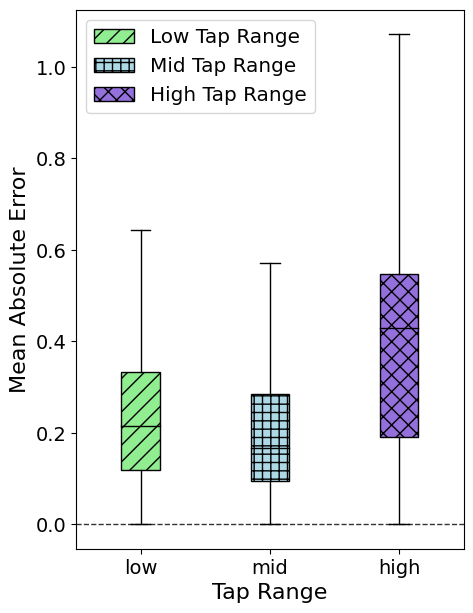

In [45]:
## Plot Tap Range Box Plot ##
fig, ax = plt.subplots(figsize=(5,7))
_tests = np.array([_tap_by_test[0][:].ravel(), _tap_by_test[2][:].ravel(), _tap_by_test[1][:].ravel()])
xt = [1,2,3]
xtl=['low','mid','high']
hatches = ['//', '++', 'xx', '||']
tt = ax.boxplot(_tests.T, patch_artist=True, showfliers=False,\
            boxprops=dict(edgecolor="black"),\
            whiskerprops=dict(color="black", linestyle='-'),\
            capprops=dict(color="black", linestyle='-'),\
            medianprops=dict(color="black", linestyle='-'))

for i, box in enumerate(tt['boxes']):
    box.set(facecolor=colors_light[i])
    mpl.rcParams['hatch.linewidth'] = 1
    mpl.rcParams['hatch.color'] = 'black'
    box.set(hatch=hatches[i])

ax.set_xticks(xt)
ax.set_xticklabels(xtl)
ax.axhline(y=0.0,color='black', alpha=0.8, linestyle='--', linewidth=1)
#ax1.set(ylim=[-0.6,0.4])
ax.set_xlabel("Tap Range", fontsize=font_size, fontfamily='sans-serif')
ax.set_ylabel("Mean Absolute Error", fontsize=font_size, fontfamily='sans-serif')
ax.tick_params(labelsize=label_size)
ax.legend([tt['boxes'][0],tt['boxes'][1],tt['boxes'][2]],("Low Tap Range","Mid Tap Range","High Tap Range"), loc='upper left', fontsize="x-large")

plt.show()

In [11]:
## Statistics of Quartiles and Tap Ranges ##
q_num = 4
q_size = _tap_by_test.shape[2]//q_num
quartiles = _tap_by_test.reshape(_tap_by_test.shape[0], q_num, _tap_by_test.shape[1], q_size) # (3,43,32) --> (3,4,43,8)
lows = quartiles[0] # (4,43,8)
mids = quartiles[2] # (4,43,8)
highs = quartiles[1] # (4,43,8)
sums=lows+mids+highs
all_tests = [lows,mids,highs,sums]
names = ["low","mid","high","sums"]

for t in range(len(all_tests)):
    test = all_tests[t]
    anova = stats.f_oneway(np.mean(test[0], axis=0), np.mean(test[1], axis=0), np.mean(test[2], axis=0), np.mean(test[3], axis=0))
    print(f"Quartile [{str(names[t])}]: {anova.statistic:.4f} P-Value: ({anova.pvalue})")
    _test = test.T
    tests_in_order = np.concatenate((test[0].ravel(), test[1].ravel(), test[2].ravel(), test[3].ravel()), axis=0)
    labels = ["q1"]*(8*43) + ["q2"]*(8*43) + ["q3"]*(8*43) + ["q4"]*(8*43)
    data = {'error':tests_in_order.ravel(), 'test_type':labels}
    data_df = pd.DataFrame(data)

    tukey = pairwise_tukeyhsd(data_df['error'], data_df['test_type'], alpha=0.05)
    tukey_df = pd.DataFrame(data=tukey._results_table.data[1:], columns=tukey._results_table.data[0])
    print(f"Tap Consistency Tukey's HSD Results: \n{tukey_df}\n") 

Quartile [low]: 6.1014 P-Value: (0.0024979326966422214)
Tap Consistency Tukey's HSD Results: 
  group1 group2  meandiff  p-adj   lower   upper  reject
0     q1     q2   -0.0449 0.0026 -0.0777 -0.0120    True
1     q1     q3   -0.0326 0.0519 -0.0654  0.0002   False
2     q1     q4   -0.0318 0.0610 -0.0647  0.0010   False
3     q2     q3    0.0122 0.7736 -0.0206  0.0450   False
4     q2     q4    0.0130 0.7378 -0.0198  0.0458   False
5     q3     q4    0.0008 0.9999 -0.0320  0.0336   False

Quartile [mid]: 0.4843 P-Value: (0.6959068480474424)
Tap Consistency Tukey's HSD Results: 
  group1 group2  meandiff  p-adj   lower  upper  reject
0     q1     q2   -0.0134 0.8352 -0.0542 0.0275   False
1     q1     q3   -0.0045 0.9921 -0.0454 0.0364   False
2     q1     q4   -0.0138 0.8222 -0.0547 0.0271   False
3     q2     q3    0.0089 0.9446 -0.0320 0.0498   False
4     q2     q4   -0.0004 1.0000 -0.0413 0.0405   False
5     q3     q4   -0.0093 0.9371 -0.0502 0.0316   False

Quartile [high]: 1.948

In [12]:
## Statistics of Quartiles and Tap Ranges ##
q_num = 4
q_size = _tap_by_test.shape[2]//q_num
quartiles = _tap_by_test.reshape(_tap_by_test.shape[0], q_num, _tap_by_test.shape[1], q_size) # (3,43,32) --> (3,4,43,8)
lows = quartiles[0] # (4,43,8)
mids = quartiles[2] # (4,43,8)
highs = quartiles[1] # (4,43,8)
sums=lows+mids+highs
all_tests = [lows,mids,highs,sums]
names = ["low","mid","high","sums"]

for t in range(len(all_tests)):
    test = all_tests[t]
    print(np.mean(test[0],axis=1).shape)
    anova = stats.f_oneway(np.mean(test[0], axis=1), np.mean(test[1], axis=1), np.mean(test[2], axis=1), np.mean(test[3], axis=1))
    print(f"Quartile [{str(names[t])}]: {anova.statistic:.4f} P-Value: ({anova.pvalue})")

    tests_in_order = np.concatenate((np.mean(test[0], axis=1), np.mean(test[1], axis=1), np.mean(test[2], axis=1), np.mean(test[3], axis=1)), axis=0)
    labels = ["q1"]*(43) + ["q2"]*(43) + ["q3"]*(43) + ["q4"]*(43)
    data = {'error':tests_in_order.ravel(), 'test_type':labels}
    data_df = pd.DataFrame(data)

    tukey = pairwise_tukeyhsd(data_df['error'], data_df['test_type'], alpha=0.05)
    tukey_df = pd.DataFrame(data=tukey._results_table.data[1:], columns=tukey._results_table.data[0])
    print(f"Tap Consistency Tukey's HSD Results: \n{tukey_df}\n") 

(43,)
Quartile [low]: 1.4952 P-Value: (0.2177296605183857)
Tap Consistency Tukey's HSD Results: 
  group1 group2  meandiff  p-adj   lower  upper  reject
0     q1     q2   -0.0449 0.1837 -0.1024 0.0127   False
1     q1     q3   -0.0326 0.4567 -0.0902 0.0249   False
2     q1     q4   -0.0318 0.4787 -0.0894 0.0257   False
3     q2     q3    0.0122 0.9462 -0.0453 0.0697   False
4     q2     q4    0.0130 0.9359 -0.0445 0.0705   False
5     q3     q4    0.0008 1.0000 -0.0567 0.0583   False

(43,)
Quartile [mid]: 0.1083 P-Value: (0.955159295035067)
Tap Consistency Tukey's HSD Results: 
  group1 group2  meandiff  p-adj   lower  upper  reject
0     q1     q2   -0.0134 0.9680 -0.0891 0.0624   False
1     q1     q3   -0.0045 0.9987 -0.0802 0.0712   False
2     q1     q4   -0.0138 0.9651 -0.0895 0.0619   False
3     q2     q3    0.0089 0.9902 -0.0668 0.0846   False
4     q2     q4   -0.0004 1.0000 -0.0761 0.0753   False
5     q3     q4   -0.0093 0.9888 -0.0850 0.0664   False

(43,)
Quartile [high]

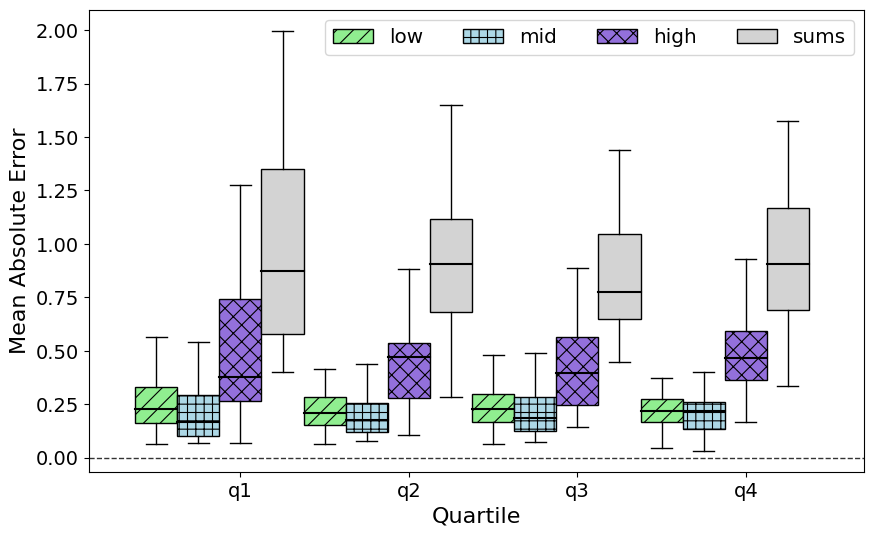

In [52]:
## Plot Quartile Box Plot ##
fig,(ax) = plt.subplots(figsize=(10,6))

quartiles = _tap_by_test.reshape(_tap_by_test.shape[0], q_num, _tap_by_test.shape[1], q_size) # (3,43,32) --> (3,4,43,8)
""" lows = quartiles[0]/42.0 # (4,43,8)
mids = quartiles[2]/42.0 # (4,43,8)
highs = quartiles[1]/42.0 # (4,43,8) """
lows = quartiles[0] # (4,43,8)
mids = quartiles[2] # (4,43,8)
highs = quartiles[1]# (4,43,8)
sums = lows+mids+highs

all_tests = [lows,mids,highs,sums]
names = ["low","mid","high","sums"]

xt = np.array([0,1,2,3], dtype=float)
widths=[0.25]*4
q_names=["q1", "q2","q3", "q4"]*4 #+ ["q2"]*4 + ["q3"]*4 + ["q4"]*4
pos = np.array([xt]+[xt+0.25]+[xt+0.5]+[xt+0.75])
xtl=q_names

mpl.rcParams['hatch.linewidth'] = 0.8
mpl.rcParams['hatch.color'] = 'grey'
hatches = ['//', '++', 'xx', '']
colors_light=['lightgreen','lightblue','mediumpurple', 'lightgrey']
colors_dark=['forestgreen', 'royalblue','indigo']
box=[]
pts=[]
_pts=[]
idx=np.array([0,1,2,3])
w=0
for t in range(len(all_tests)):
    test = all_tests[t]
    _test = np.mean(test, axis=2).T
    bp = ax.boxplot(_test, patch_artist=True, positions=pos[t], showfliers=False, widths=widths,\
                boxprops=dict(facecolor=colors_light[t], color="black", hatch=hatches[t]),\
                whiskerprops=dict(color="black", linestyle='-'),\
                capprops=dict(color="black", linestyle='-'),\
                medianprops=dict(color="black", linestyle='-', linewidth=1.5))
    _idx=idx+w
    pts.append(np.mean(_test, axis=0))
    _pts.append(_idx)
    w+=0.25
    box.append(bp['boxes'][0])
ax.scatter(_pts, pts, color='black', marker='x')

mpl.rcParams['hatch.color'] = 'black'
ax.set_xticks([0.5, 1.5, 2.5, 3.5])
ax.set_xticklabels(["q1", "q2","q3", "q4"])
ax.set(xlim=[-0.4,4.2])
ax.axhline(y=0.0,color='black', alpha=0.8, linestyle='--', linewidth=1)
ax.legend(box,(names), loc='upper right', fontsize="x-large",ncols=4)

#ax.set_title(f"Mean Err. by Quartile", fontsize=12, fontfamily='serif',fontweight='book')
ax.set_xlabel("Quartile", fontsize=font_size, fontfamily='sans-serif')
ax.set_ylabel("Mean Absolute Error", fontsize=font_size, fontfamily='sans-serif')
ax.tick_params(labelsize=label_size)


In [14]:
# ANOVA and Tukey's HSD On Quartiles
q_n = _tap_by_test.shape[2]//4
quartiles = _tap_by_test.reshape(_tap_by_test.shape[0], 4, _tap_by_test.shape[1], q_n)

labels = ["null"]*(8*43) + ["low"]*(8*43) + ["high"]*(8*43) + ["mid"]*(8*43)
neutral = np.zeros(quartiles[0][0].shape)
quartiles_in_order_q1 = np.concatenate((neutral.ravel(), \
                                quartiles[0][0][:].ravel(), \
                                quartiles[1][0][:].ravel(), \
                                quartiles[2][0][:].ravel()), axis=0)
quartiles_in_order_q2 = np.concatenate((neutral.ravel(), \
                                quartiles[0][1][:].ravel(), \
                                quartiles[1][1][:].ravel(), \
                                quartiles[2][1][:].ravel()), axis=0)
quartiles_in_order_q3 = np.concatenate((neutral.ravel(), \
                                quartiles[0][2][:].ravel(), \
                                quartiles[1][2][:].ravel(), \
                                quartiles[2][2][:].ravel()), axis=0)
quartiles_in_order_q4 = np.concatenate((neutral.ravel(), \
                                quartiles[0][3][:].ravel(), \
                                quartiles[1][3][:].ravel(), \
                                quartiles[2][3][:].ravel()), axis=0)

q_dict={
    'q1':quartiles_in_order_q1,
    'q2':quartiles_in_order_q2,
    'q3':quartiles_in_order_q3,
    'q4':quartiles_in_order_q4
}
q_names=["q1","q2","q3","q4"]

quarts = np.mean(quartiles, axis=0)
q_labels = ["q1"]*(8*43) + ["q2"]*(8*43) + ["q3"]*(8*43) + ["q4"]*(8*43)    
anova = stats.f_oneway(np.mean(neutral, axis=0),np.mean(quarts[0], axis=0),np.mean(quarts[1], axis=0),np.mean(quarts[2], axis=0))
print(anova)
for q in q_dict:
    print(f"{q} ----------")
    i = int(q[-1:])-1 #gets num
    line = []

    group1 = np.mean(neutral, axis=0)
    group2 = np.mean(quarts[i],axis=0)
    ttest = stats.ttest_ind(group1,group2)

    print(f"mean: {np.round(np.mean(group2),4)}, sd: {np.round(np.std(group2),4)}")
    print(f"t-test v Null: {ttest.statistic:.4f} P-Value: ({ttest.pvalue}) df={len(group1)+len(group2)-2} {q}")
    anova = stats.f_oneway(np.mean(neutral, axis=0),np.mean(quarts[i], axis=0))
print()    

qrtle=[]
for i in range(len(quarts)):
    qrtle.append(quarts[i].ravel())
qrtle=np.array(qrtle)
data = {'error':qrtle.ravel(), 'test_type':q_labels}
data_df = pd.DataFrame(data)

tukey = pairwise_tukeyhsd(data_df['error'], data_df['test_type'], alpha=0.05)
tukey_df = pd.DataFrame(data=tukey._results_table.data[1:], columns=tukey._results_table.data[0])
print(f"Tap Consistency Tukey's HSD Results for {q}: \n{tukey_df}\n")


F_onewayResult(statistic=750.7942902585716, pvalue=7.629269767838368e-27)
q1 ----------
mean: 0.335, sd: 0.0158
t-test v Null: -56.0794 P-Value: (7.048781904727186e-18) df=14 q1
q2 ----------
mean: 0.2978, sd: 0.0185
t-test v Null: -42.5330 P-Value: (3.3104152693928454e-16) df=14 q2
q3 ----------
mean: 0.3188, sd: 0.0188
t-test v Null: -44.8467 P-Value: (1.5850077418518221e-16) df=14 q3
q4 ----------
mean: 0.3156, sd: 0.0265
t-test v Null: -31.5423 P-Value: (2.0878435789590424e-14) df=14 q4

Tap Consistency Tukey's HSD Results for q4: 
  group1 group2  meandiff  p-adj   lower   upper  reject
0     q1     q2   -0.0371 0.0472 -0.0740 -0.0003    True
1     q1     q3   -0.0162 0.6702 -0.0530  0.0206   False
2     q1     q4   -0.0193 0.5307 -0.0562  0.0175   False
3     q2     q3    0.0209 0.4607 -0.0159  0.0578   False
4     q2     q4    0.0178 0.5995 -0.0190  0.0546   False
5     q3     q4   -0.0031 0.9963 -0.0400  0.0337   False



In [15]:
music_data = [
    [1.50, 0.00, 0.00, 0.50],
    [1.50, 0.50, 0.50, 1.50],
    [4.50, 4.50, 4.50, 3.00],
    [4.50, 1.50, 1.50, 4.50],
    [3.00, 0.00, 0.00, 4.50],
    [1.50, 3.00, 0.50, 0.50],
    [4.50, 4.50, 4.50, 3.00],
    [4.50, 4.50, 4.50, 4.50],
    [0.50, 0.00, 0.50, 4.50],
    [4.50, 4.50, 4.50, 3.00],
    [3.00, 3.00, 0.00, 0.50],
    [4.50, 4.50, 4.50, 1.50],
    [4.50, 1.50, 4.50, 3.00],
    [4.50, 4.50, 4.50, 4.50],
    [4.50, 3.00, 4.50, 3.00],
    [4.50, 4.50, 0.00, 0.50],
    [4.50, 3.00, 3.00, 3.00],
    [4.50, 4.50, 4.50, 1.50],
    [4.50, 4.50, 4.50, 0.00],
    [3.00, 4.50, 0.50, 0.00],
    [4.50, 4.50, 4.50, 4.50],
    [4.50, 4.50, 4.50, 4.50],
    [0.50, 0.00, 0.00, 3.00],
    [4.50, 4.50, 4.50, 1.50],
    [1.50, 0.00, 0.00, 1.50],
    [4.50, 1.50, 1.50, 3.00],
    [4.50, 0.50, 3.00, 1.50],
    [4.50, 4.50, 4.50, 3.00],
    [4.50, 0.00, 3.00, 3.00],
    [4.50, 0.50, 4.50, 3.00],
    [4.50, 4.50, 4.50, 1.50],
    [4.50, 3.00, 0.00, 0.50],
    [4.50, 3.00, 1.50, 0.50],
    [4.50, 3.00, 3.00, 1.50],
    [4.50, 4.50, 1.50, 4.00],
    [4.50, 4.50, 4.50, 3.00],
    [4.50, 4.50, 3.00, 1.50],
    [4.50, 3.00, 4.50, 1.50],
    [4.50, 4.50, 4.50, 1.50],
    [4.50, 4.50, 4.50, 3.00],
    [4.50, 0.00, 3.00, 0.50],
    [4.50, 4.50, 4.50, 4.50],
    [4.50, 4.50, 4.50, 3.00]
]

In [16]:
subj_nomusic=[]
subj_music=[]
questions=["play_music", "study_music", "perform", "interaction"]
data=music_data
for i in range(len(data)):
    if float(data[i][0])<3.1:
        subj_nomusic.append(i)
    else: 
        subj_music.append(i)
print(f" {len(subj_music)} {len(subj_nomusic)}")
print(len(subj_nomusic)/n_subjects)

 34 9
0.20930232558139536


In [17]:
## Statistics of Quartiles and Tap Ranges ##
q_num = 4
q_size = _tap_by_test.shape[2]//q_num
quartiles = _tap_by_test.reshape(_tap_by_test.shape[0], q_num, _tap_by_test.shape[1], q_size) # (3,43,32) --> (3,4,43,8)
lows = quartiles[0] # (4,43,8)
mids = quartiles[2] # (4,43,8)
highs = quartiles[1] # (4,43,8)
sums=lows+mids+highs
print(sums.shape)
all_tests = [lows,mids,highs,sums]
names = ["lows","mids","highs","sums"]

for t in range(len(all_tests)):
    test = all_tests[t]
    anova = stats.f_oneway(np.mean(test[0], axis=0), np.mean(test[1], axis=0), np.mean(test[2], axis=0), np.mean(test[3], axis=0))
    print(f"Quartile [{str(names[t])}]: {anova.statistic:.4f} P-Value: ({anova.pvalue})")

    tests_in_order = np.concatenate((test[0].ravel(), test[1].ravel(), test[2].ravel(), test[3].ravel()), axis=0)
    labels = ["q1"]*(8*43) + ["q2"]*(8*43) + ["q3"]*(8*43) + ["q4"]*(8*43)    
    data = {'error':tests_in_order.ravel(), 'test_type':labels}
    data_df = pd.DataFrame(data)

    tukey = pairwise_tukeyhsd(data_df['error'], data_df['test_type'], alpha=0.05)
    tukey_df = pd.DataFrame(data=tukey._results_table.data[1:], columns=tukey._results_table.data[0])
    print(f"Tap Consistency Tukey's HSD Results: \n{tukey_df}\n") 

(4, 43, 8)
Quartile [lows]: 6.1014 P-Value: (0.0024979326966422214)
Tap Consistency Tukey's HSD Results: 
  group1 group2  meandiff  p-adj   lower   upper  reject
0     q1     q2   -0.0449 0.0026 -0.0777 -0.0120    True
1     q1     q3   -0.0326 0.0519 -0.0654  0.0002   False
2     q1     q4   -0.0318 0.0610 -0.0647  0.0010   False
3     q2     q3    0.0122 0.7736 -0.0206  0.0450   False
4     q2     q4    0.0130 0.7378 -0.0198  0.0458   False
5     q3     q4    0.0008 0.9999 -0.0320  0.0336   False

Quartile [mids]: 0.4843 P-Value: (0.6959068480474424)
Tap Consistency Tukey's HSD Results: 
  group1 group2  meandiff  p-adj   lower  upper  reject
0     q1     q2   -0.0134 0.8352 -0.0542 0.0275   False
1     q1     q3   -0.0045 0.9921 -0.0454 0.0364   False
2     q1     q4   -0.0138 0.8222 -0.0547 0.0271   False
3     q2     q3    0.0089 0.9446 -0.0320 0.0498   False
4     q2     q4   -0.0004 1.0000 -0.0413 0.0405   False
5     q3     q4   -0.0093 0.9371 -0.0502 0.0316   False

Quartile 

In [18]:

lows = _tap_by_test[0] # (43,32)
mids = _tap_by_test[2] # 
highs = _tap_by_test[1]#

music_lows = lows[subj_music[0]]
music_mids = mids[subj_music[0]]
music_highs = highs[subj_music[0]]
music_sums = music_lows+music_mids+music_highs

no_music_lows = lows[subj_nomusic[0]]
no_music_mids = mids[subj_nomusic[0]]
no_music_highs = highs[subj_nomusic[0]]
no_music_sums = no_music_lows+no_music_mids+no_music_highs

no_music_all_tests = [no_music_lows,no_music_mids,no_music_highs,no_music_sums]
music_all_tests = [music_lows,music_mids,music_highs,music_sums]

for t in range(len(music_all_tests)):
    m_test=music_all_tests
    nm_test=no_music_all_tests
    """
    print("--MUSICAL--") 
    test = music_all_tests
    m_test=music_all_tests
    anova = stats.f_oneway(test[0], test[1], test[2], test[3])
    print(f"Quartile [{str(names[t])}]: {anova.statistic:.4f} P-Value: ({anova.pvalue})")

    tests_in_order = np.concatenate((test[0].ravel(), test[1].ravel(), test[2].ravel(), test[3].ravel()), axis=0)
    labels = ["low"]*(len(test[0])) + ["mid"]*(len(test[1])) + ["high"]*(len(test[2])) + ["sum"]*(len(test[3]))
    
    data = {'error':tests_in_order.ravel(), 'test_type':labels}
    data_df = pd.DataFrame(data)

    tukey = pairwise_tukeyhsd(data_df['error'], data_df['test_type'], alpha=0.05)
    tukey_df = pd.DataFrame(data=tukey._results_table.data[1:], columns=tukey._results_table.data[0])
    print(f"Tap Consistency Tukey's HSD Results: \n{tukey_df[tukey_df.reject==True]}\n")

    print("--NON MUSICAL--")
    test = no_music_all_tests
    nm_test=no_music_all_tests
    anova = stats.f_oneway(test[0], test[1], test[2], test[3])
    print(f"Quartile [{str(names[t])}]: {anova.statistic:.4f} P-Value: ({anova.pvalue})")

    tests_in_order = np.concatenate((test[0].ravel(), test[1].ravel(), test[2].ravel(), test[3].ravel()), axis=0)
    labels = ["low"]*(len(test[0])) + ["mid"]*(len(test[1])) + ["high"]*(len(test[2])) + ["sum"]*(len(test[3]))
    data = {'error':tests_in_order.ravel(), 'test_type':labels}
    data_df = pd.DataFrame(data)

    tukey = pairwise_tukeyhsd(data_df['error'], data_df['test_type'], alpha=0.05)
    tukey_df = pd.DataFrame(data=tukey._results_table.data[1:], columns=tukey._results_table.data[0])
    print(f"Tap Consistency Tukey's HSD Results: \n{tukey_df[tukey_df.reject==True]}\n")
    """

    print("--COMPARE--")
    ttest = stats.ttest_ind(m_test[t], nm_test[t],equal_var=False)
    print(f"--> WELCHs T-TEST [{str(names[t])}]: {ttest.statistic:.4f} P-Value: ({ttest.pvalue})")

    anova=stats.f_oneway(m_test[t], nm_test[t])
    print(f"MUSIC/NON [{str(names[t])}]: {anova.statistic:.4f} P-Value: ({anova.pvalue})")

    compare = np.concatenate((m_test[t].ravel(), nm_test[t].ravel()), axis=0)
    lbls = ["musical"]*(len(m_test[t])) + ["non"]*(len(nm_test[t]))    
    data = {'error':compare.ravel(), 'test_type':lbls}
    data_df = pd.DataFrame(data)

    tukey = pairwise_tukeyhsd(data_df['error'], data_df['test_type'], alpha=0.05)
    tukey_df = pd.DataFrame(data=tukey._results_table.data[1:], columns=tukey._results_table.data[0])
    print(f"{tukey_df[tukey_df.reject==True]}\n")

anova=stats.f_oneway(music_lows, music_mids, music_highs)
print(f"MUSIC [{str(names[t])}]: {anova.statistic:.4f} P-Value: ({anova.pvalue})")

tests_in_order = np.concatenate((music_lows.ravel(), music_mids.ravel(), music_highs.ravel()), axis=0)
n = 32
labels = ["low"]*(n) + ["mid"]*(n) + ["high"]*(n)
data = {'error':tests_in_order.ravel(), 'test_type':labels}
data_df = pd.DataFrame(data)

tukey = pairwise_tukeyhsd(data_df['error'], data_df['test_type'], alpha=0.05)
tukey_df = pd.DataFrame(data=tukey._results_table.data[1:], columns=tukey._results_table.data[0])
print(f"{tukey_df}\n") 

anova=stats.f_oneway(no_music_lows, no_music_mids, no_music_highs)
print(f"MUSIC/NON [{str(names[t])}]: {anova.statistic:.4f} P-Value: ({anova.pvalue})")

tests_in_order = np.concatenate((no_music_lows.ravel(), no_music_mids.ravel(), no_music_highs.ravel()), axis=0)
n = 32
labels = ["low"]*(n) + ["mid"]*(n) + ["high"]*(n)
data = {'error':tests_in_order.ravel(), 'test_type':labels}
data_df = pd.DataFrame(data)

tukey = pairwise_tukeyhsd(data_df['error'], data_df['test_type'], alpha=0.05)
tukey_df = pd.DataFrame(data=tukey._results_table.data[1:], columns=tukey._results_table.data[0])
print(f"{tukey_df}\n") 

--COMPARE--
--> WELCHs T-TEST [lows]: -2.4818 P-Value: (0.015798418265122183)
MUSIC/NON [lows]: 6.1592 P-Value: (0.01579653325959037)
    group1 group2  meandiff  p-adj  lower  upper  reject
0  musical    non    0.1830 0.0158 0.0356 0.3305    True

--COMPARE--
--> WELCHs T-TEST [mids]: -2.2302 P-Value: (0.029957216080872248)
MUSIC/NON [mids]: 4.9739 P-Value: (0.02936130708794602)
    group1 group2  meandiff  p-adj  lower  upper  reject
0  musical    non    0.1496 0.0294 0.0155 0.2836    True

--COMPARE--
--> WELCHs T-TEST [highs]: -2.2032 P-Value: (0.03152927572999263)
MUSIC/NON [highs]: 4.8541 P-Value: (0.03130457753382906)
    group1 group2  meandiff  p-adj  lower  upper  reject
0  musical    non    0.2507 0.0313 0.0232 0.4782    True

--COMPARE--
--> WELCHs T-TEST [sums]: -3.3954 P-Value: (0.0012688006997964487)
MUSIC/NON [sums]: 11.5286 P-Value: (0.0012003859000431444)
    group1 group2  meandiff  p-adj  lower  upper  reject
0  musical    non    0.5833 0.0012 0.2399 0.9268    True


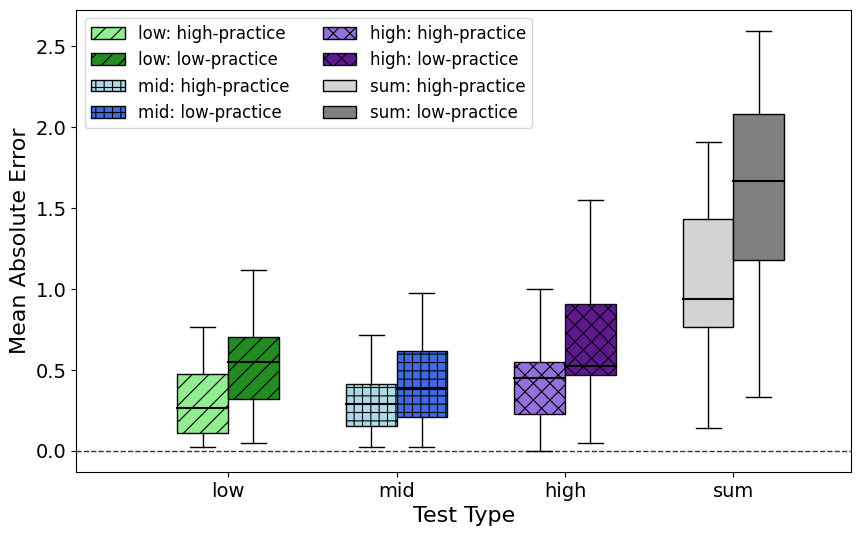

In [55]:

fig,(ax) = plt.subplots(figsize=(10,6))
names = ["lows","mids","highs","sums"]
xt = np.array([0,1,2,3], dtype=float)
widths=[0.30]
xtl=q_names
mpl.rcParams['hatch.linewidth'] = 0.8
mpl.rcParams['hatch.color'] = 'grey'
hatches = ['//', '++', 'xx', '']
colors_light=['lightgreen','lightblue','mediumpurple', 'lightgrey']
colors_dark=['forestgreen', 'royalblue','indigo',"grey"]

box=[]
for t in range(len(music_all_tests)):
    music_test = music_all_tests[t]
    bp = ax.boxplot(np.array(music_all_tests[t]).T, patch_artist=True, positions=[t+0.35],showfliers=False, widths=widths,\
                boxprops=dict(facecolor=colors_light[t], color="black", hatch=hatches[t]),\
                whiskerprops=dict(color="black", linestyle='-'),\
                capprops=dict(color="black", linestyle='-'),\
                medianprops=dict(color="black", linestyle='-', linewidth=1.5))
    a=0.9 if t==2 else 1
    bp1 = ax.boxplot(np.array(no_music_all_tests[t]).T, positions=[t+0.65], patch_artist=True, showfliers=False, widths=widths,\
                boxprops=dict(facecolor=colors_dark[t], color="black",alpha=a, hatch=hatches[t]),\
                whiskerprops=dict(color="black", linestyle='-'),\
                capprops=dict(color="black", linestyle='-'),\
                medianprops=dict(color="black", linestyle='-', linewidth=1.5))
    
    box.append(bp['boxes'][0])
    box.append(bp1['boxes'][0])

mpl.rcParams['hatch.color'] = 'black'
ax.set_xticks([0.5, 1.5, 2.5, 3.5])
ax.set_xticklabels(["low", "mid","high", "sum"])
ax.set(xlim=[-0.4,4.2])
ax.axhline(y=0.0,color='black', alpha=0.8, linestyle='--', linewidth=1) 
legend_names=["low: high-practice","low: low-practice","mid: high-practice","mid: low-practice","high: high-practice",\
              "high: low-practice","sum: high-practice","sum: low-practice"]
ax.legend(box,(legend_names), loc='upper left', fontsize="large", ncols=2)

ax.set_xlabel("Test Type", fontsize=font_size, fontfamily='sans-serif')
ax.set_ylabel("Mean Absolute Error", fontsize=font_size, fontfamily='sans-serif')
ax.tick_params(labelsize=label_size)
